# Transfer Learning with VGG19 to detect HLB


Transfer learning employing the database of leaves with and without HLB without the mask

Accessing to Google Drive and importing the libraries

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

Time_start = datetime.now()
print("\n Start time:", Time_start)

# !pip install tensorflow
import tensorflow as tf
import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory



 Start time: 2024-12-29 00:53:04.245806


Directories that are going to be used and number of elements by class in training and validation

In [2]:
ModelFolder = (r'C:\Users\jkrlo\Documents\Universidad\Research Projects\2023 Plantas Postdoc\Classify HLB Leaves with Transfer Learning\Arquitecturas\VGG19')
#ImagesFolder = ('/content/drive/MyDrive/Research/HLB Classification/Database')
ImagesSplittedFolder = (r'C:\Users\jkrlo\Documents\Universidad\Research Projects\2023 Plantas Postdoc\Classify HLB Leaves with Transfer Learning\Dataset-Splitted')

Training_Folder = (r'C:\Users\jkrlo\Documents\Universidad\Research Projects\2023 Plantas Postdoc\Classify HLB Leaves with Transfer Learning\Dataset-Splitted\train')
Validation_Folder = (r'C:\Users\jkrlo\Documents\Universidad\Research Projects\2023 Plantas Postdoc\Classify HLB Leaves with Transfer Learning\Dataset-Splitted\val')



SubFolders_Training = os.listdir(Training_Folder)
print("Training images by category:")

for iSubFolder in range(len(SubFolders_Training)):
  CurrentFolder = os.path.join(Training_Folder, SubFolders_Training[iSubFolder])
  print(SubFolders_Training[iSubFolder], len(os.listdir(CurrentFolder)))

SubFolders_Validation = os.listdir(Validation_Folder)
print("\nValidation images by category:")

for iSubFolder in range(len(SubFolders_Validation)):
  CurrentFolder = os.path.join(Validation_Folder, SubFolders_Validation[iSubFolder])
  print(SubFolders_Validation[iSubFolder], len(os.listdir(CurrentFolder)))


Training images by category:
0 Sanas 273
1 HLB 349

Validation images by category:
0 Sanas 69
1 HLB 89


Definition of the training and validation datasets with the characteristics of the neural network

In [3]:
Batch_Size = 32
Img_Size = (224, 224)

Train_Dataset = image_dataset_from_directory(Training_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Validation_Dataset_Original = image_dataset_from_directory(Validation_Folder,
                                             shuffle = True,
                                             batch_size = Batch_Size,
                                             image_size = Img_Size)

Found 622 files belonging to 2 classes.
Found 158 files belonging to 2 classes.


Verify the first 9 images and labels of the dataset

In [4]:
sorted(os.listdir(Training_Folder))

['0 Sanas', '1 HLB']

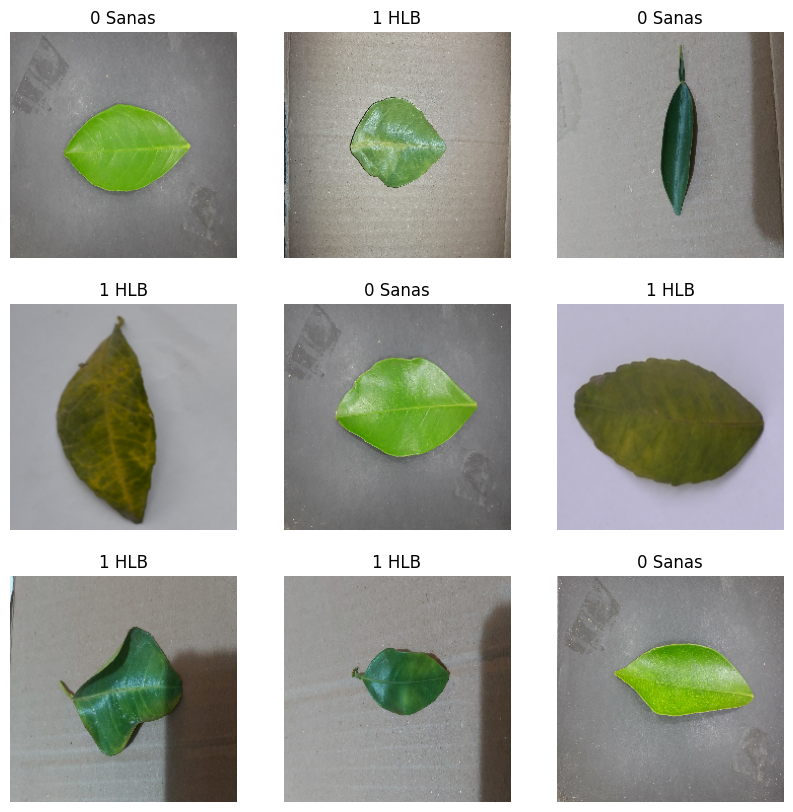

In [5]:
class_names = Train_Dataset.class_names

class_names = Train_Dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in Train_Dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.savefig(os.path.join(ModelFolder, '01 01 Imagenes Prueba.jpg'))


A test dataset is created.

Determine the validation dataset employing a lot of data batches *tf.data.experimental.cardinality*



In [6]:
val_batches = tf.data.experimental.cardinality(Validation_Dataset_Original)
test_dataset = Validation_Dataset_Original.take(val_batches // 5)
Validation_Dataset = Validation_Dataset_Original.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(Validation_Dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 4
Number of test batches: 1


In [7]:
Autotune = tf.data.AUTOTUNE

Train_Dataset = Train_Dataset.prefetch(buffer_size=Autotune)
Validation_Dataset = Validation_Dataset.prefetch(buffer_size=Autotune)
test_dataset = test_dataset.prefetch(buffer_size=Autotune)

Data augmented

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomBrightness(factor=0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation([0, 0.99]),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  tf.keras.layers.RandomZoom(height_factor = [-0.4, 0.4], width_factor=[-0.4, 0.4])])

Showing the augmented data

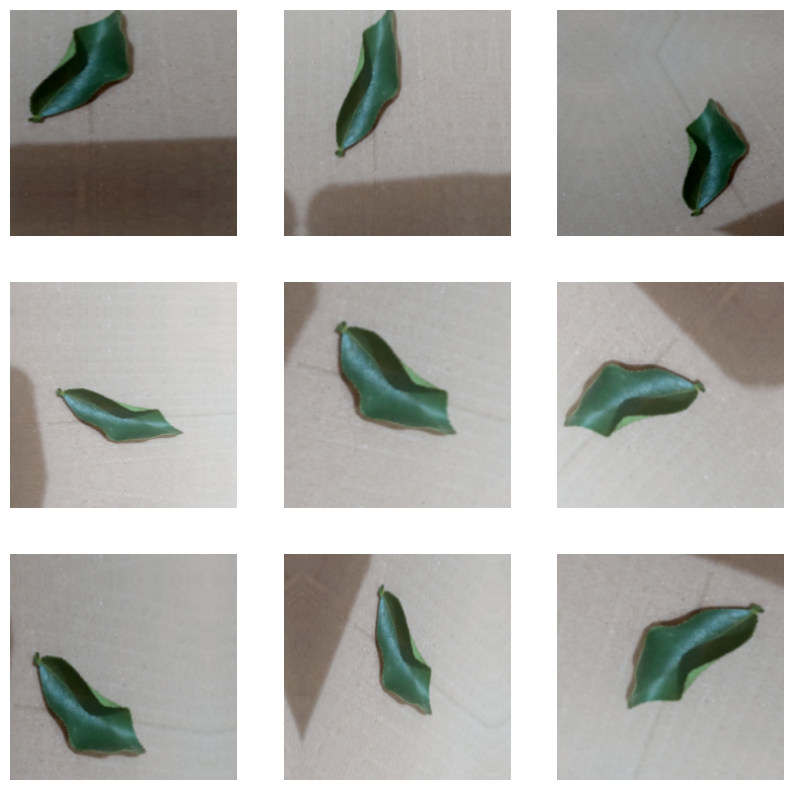

In [9]:
for image, _ in Train_Dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

plt.savefig(os.path.join(ModelFolder, '01 02 Augmented Images.jpg'))

Changing the **scale of the pixels values to use VGG19**

They should be between [-1 and 1], at this momment, they are between [0, 255]


In [10]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

#rescale = tf.keras.Sequential([layers.Rescaling(1./127.5, offset= -1)])
from tensorflow.keras import layers

rescale = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])

The *bottle neeck layer* is employed to preserve the characteristics with more generalities in comparition with the final layer of the MobilNet model.

The model is employed with the weights trained in ImageNet, when *include_top = false* as argument, the classification layers are not chaarged in the model

In [11]:
# Create the base model from the pre-trained model VGG19
Img_Shape = Img_Size + (3,)
base_model = tf.keras.applications.VGG19(input_shape = Img_Shape,
                                               include_top = False,
                                               weights = 'imagenet')
image_batch, label_batch = next(iter(Train_Dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 512)


Feature extraction

Convolutional base created is frozen and used as a feature extractor. A classification is added at the top and trains the classificatior at the superior level (last layers).

Frozen of the convolutional base is realized with *layer.trainable = False* avoiding that the weights of a specific layer get refreshed during the training.


In [12]:
base_model.trainable = False


**Special note about *BatchNormalization* layers**

A lot of models contains *tf.keras.layers.BatchNormalization*, this is  special case and special warnings should be takenat fine tuning.

When *layer.trainable = False* is employed, BatchNormalization layers is going to execute as inference mode and is not going to refresh the average and variance statistics.

When a model with BatchNormalization layers is unfrozen to make a fine tuning, it should keep the BatchNormalization layers in inference employing *training = False* when is called the base model.

If this is not realized, the refresh applied to non trainable weights will destroy the learned by the model.

In [13]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

**Add a clasification header**


In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


Apply a *tf.keras.layers.Dense*  to convert characteristics in one single prediction per image.
An activation layer is not necessary here because this prediction will be treated as a logit or a prime prediction.

**Positive numbers predict the class 1, while negative numbers precict the class 0.**

In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build the chain model with the data augmented, scale change, *base_model* layers and extracting the characteristics employing the functional API Keras.

As previosly where mentioned, use *training = False* because our model has a BarchNormalization layer.

In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compile the model**

Compile the model before trained. A binary lost cross entropy is employed with *from_logits = True* because we have two clases and a lineal output.

In [17]:
base_learning_rate = 0.0001
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#model.compile(keras.optimizers.SGD(), loss='mse') # CHECK IF LOSS 'mse' IS AN OPTION
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 224, 224, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 224, 224)          │               0 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 224, 224)          │               0 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 224, 224)          │               0 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack (Stack)                 │ (None, 224, 224, 3)       │               0 │ get_item[0][0],            │
│                               │                           │                 │ get_item_1[0][0],          │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 224, 224, 3)       │               0 │ stack[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg19 (Functional)            │ (None, 7, 7, 512)         │      20,024,384 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 512)               │               0 │ vgg19[0][0]                │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1)                 │             513 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 20,024,897 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [18]:
len(model.trainable_variables)

2

**Training the model**

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(Validation_Dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(Train_Dataset,
                    epochs=initial_epochs,
                    callbacks=[callback],
                    validation_data=Validation_Dataset_Original)



4/4 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - accuracy: 0.4571 - loss: 1.4496
initial loss: 1.34
initial accuracy: 0.48
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 251s 12s/step - accuracy: 0.4508 - loss: 1.3563 - val_accuracy: 0.5000 - val_loss: 1.0644
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 292s 15s/step - accuracy: 0.4381 - loss: 1.1621 - val_accuracy: 0.5316 - val_loss: 0.9585
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 298s 15s/step - accuracy: 0.5034 - loss: 1.0643 - val_accuracy: 0.5570 - val_loss: 0.9016
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 318s 16s/step - accuracy: 0.4450 - loss: 1.0751 - val_accuracy: 0.5759 - val_loss: 0.8683
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 330s 17s/step - accuracy: 0.4854 - loss: 1.0867 - val_accuracy: 0.5823 - val_loss: 0.8457
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 358s 18s/step - accuracy: 0.4974 - loss: 0.9912 - val_accuracy: 0.5886 - val_loss: 0.8271
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.4984 - loss: 1.0442 - val_accuracy: 0.5886 - val_loss:

In [20]:
# First Training Time
First_Training = datetime.now()

print("\n Start time:", Time_start)
print("\n End time of the first training:", First_Training)
print('\n Duration: {}'.format(First_Training - Time_start))


 Start time: 2024-12-29 00:53:04.245806

 End time of the first training: 2024-12-29 01:37:23.266523

 Duration: 0:44:19.020717


**Learning Curves**

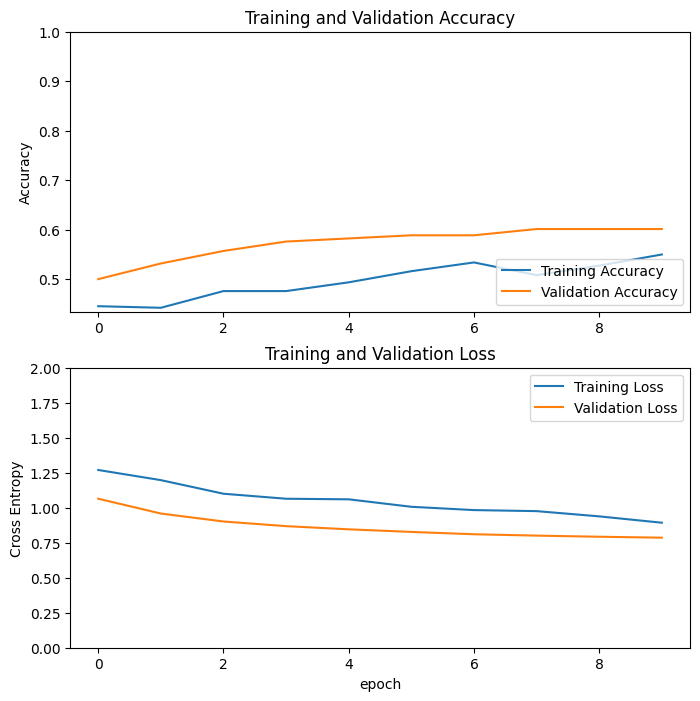

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.savefig(os.path.join(ModelFolder, '01 03 Training and Validation Accuracy.jpg'))


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(ModelFolder, '01 03 Learning Curves.jpg'))
plt.show()


In [22]:
os.chdir(ModelFolder)
model.save('01_VGG19_NoFineTuning.keras')

# Fine Tuning

We are going to tune:

*   Learning rate
*   No. of epochs

We are going to unfreeze top layers of the model



In [23]:
# Setting the top layers as trainable
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

# This step improves the accuracy of the model by a few steps
#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#              metrics=['accuracy'])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

#model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#              loss=keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=[keras.metrics.BinaryAccuracy()])

Number of layers in the base model:  22


Compile the model

In [24]:
model.summary()

len(model.trainable_variables)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 224, 224, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 224, 224)          │               0 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 224, 224)          │               0 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 224, 224)          │               0 │ sequential[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack (Stack)                 │ (None, 224, 224, 3)       │               0 │ get_item[0][0],            │
│                               │                           │                 │ get_item_1[0][0],          │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 224, 224, 3)       │               0 │ stack[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg19 (Functional)            │ (None, 7, 7, 512)         │      20,024,384 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 512)               │               0 │ vgg19[0][0]                │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1)                 │             513 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 20,024,897 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

2

Continue with the training model

In [25]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(Train_Dataset,
                         epochs=total_epochs,
                         callbacks=[callback],
                         initial_epoch=history.epoch[-1],
                         validation_data=Validation_Dataset_Original)


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 171s 8s/step - accuracy: 0.5139 - loss: 1.0014 - val_accuracy: 0.6013 - val_loss: 0.7842
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step - accuracy: 0.5230 - loss: 0.9784 - val_accuracy: 0.6013 - val_loss: 0.7820
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 168s 8s/step - accuracy: 0.5081 - loss: 1.0165 - val_accuracy: 0.6013 - val_loss: 0.7792


In [26]:
# Fine Tuning Training Time
Fine_Tuning_Time = datetime.now()

print("\n Start time:", Time_start)
print("\n End time of the first training:", First_Training)
print("\n End time of the fine tuning training:", Fine_Tuning_Time)
print('\n Duration of the fine tuning training: {}'.format(Fine_Tuning_Time - First_Training))


 Start time: 2024-12-29 00:53:04.245806

 End time of the first training: 2024-12-29 01:37:23.266523

 End time of the fine tuning training: 2024-12-29 01:45:51.715901

 Duration of the fine tuning training: 0:08:28.449378


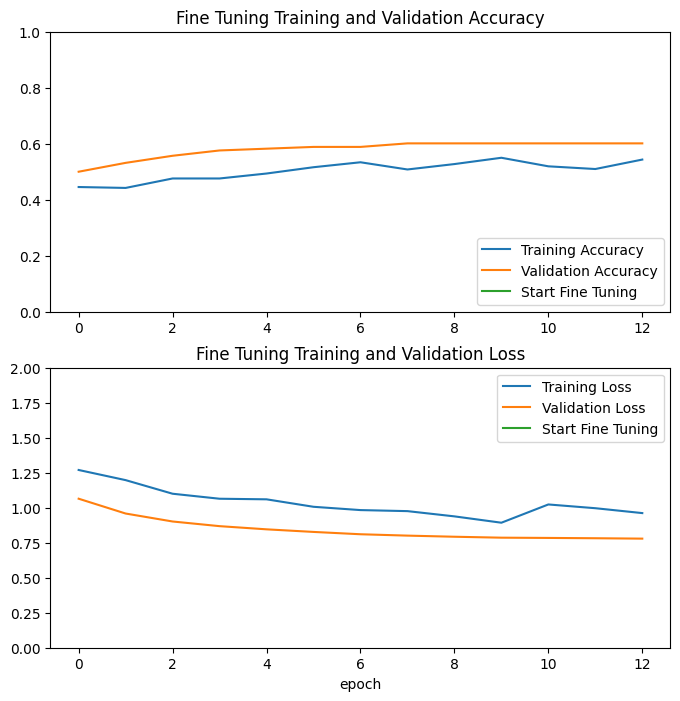

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs,initial_epochs],
         #plt.ylim(),  color = 'red',
         label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Fine Tuning Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs,initial_epochs],
         #plt.ylim(), color = 'red',
         label='Start Fine Tuning') # CHANGE COLOR TO RED OR SOMETHING
plt.legend(loc='upper right')
plt.title('Fine Tuning Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(ModelFolder, '01 04 Learning Curves Fine Tuning.jpg'))
plt.show()

In [28]:
model.save('01_VGG19_FineTuning.keras')